# PHYS305 project: Simulate a neutrino beamline

xx

Project objectives:
- Describe the geometry of the NuMI neutrino beamline
- Develop a particle tracker, propagating particles through electric and magnetic fields by integrating the equation of motion using the Euler and Runge-Kutta 2nd and 4th order methods.
- Simulate the production of charged pions in proton - Graphite target interactions using the Sandford-Wang parameterization.
- Simulate the propagation and decay of charged pions.
- Estimate the neutrino flux

The code and examples below are a starting point for further exploration.

*For enquiries, e-mail **Prof. Costas Andreopoulos** <c.andreopoulos @ cern.ch>*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from scipy.constants import c    # Speed of light
from scipy.constants import e    # Electron charge
from scipy.constants import mu_0 # Permeability of free space

## NuMI beamline description

In [43]:
class NuMI:
    """
    A description of the NuMI beamline.
    """

    # Define horn shape parameters
    target_radius       = 0.003 # m
    target_length       = 0.94  # m
    horn_length         = 3.0   # Length of each horn (m)
    horn_distance       = 0.5   #
    inner_radius_horn1  = lambda z: 0.01 + 0.03 * (z / NuMI.horn_length) ** 2  # Parabolic shape
    inner_radius_horn2  = lambda z: 0.10 + 0.05 * (z / NuMI.horn_length) ** 2  # Parabolic shape
    outer_radius_horn1  = 0.3 #
    outer_radius_horn2  = 0.5 #
    decay_pipe_radius   = 1.0 #
    decay_pipe_length   = 675.0 #
    hadron_abs_length   = 5.0 #
    hadron_hose_radius  = 0.002 #
    current_horn1       = 2.E+5 # A
    current_horn2       = 2.E+5 # A
    current_hadron_hose = 1.E+5 # A
    z_target            = 0
    z_horn1             = z_target + target_length
    z_horn2             = z_horn1 + horn_length + horn_distance
    z_decay_pipe        = z_horn2 + horn_length + hadron_abs_length 

    def __init__(self, with_hadron_hose=True):
        self._with_hadron_hose = with_hadron_hose
        return
    
    def draw_beamline_yz(self,fig,ax,yrange,zrange,label):
        
        zv = np.linspace(0, NuMI.horn_length, 100)
        r_inner_horn1 = np.array([NuMI.inner_radius_horn1(z) for z in zv])
        r_inner_horn2 = np.array([NuMI.inner_radius_horn2(z) for z in zv])
        r_outer_horn1 = np.full_like(zv, NuMI.outer_radius_horn1) 
        r_outer_horn2 = np.full_like(zv, NuMI.outer_radius_horn2) 

        # Target 
        ax.add_patch(
            patches.Rectangle(
                (NuMI.z_target,-NuMI.target_radius),
                NuMI.target_length,
                2*NuMI.target_radius,
                color="black",label="Target"))

        # Horn 1
        ax.fill_between(
            zv + NuMI.z_horn1, 
            -r_inner_horn1,  r_inner_horn1, 
            color="gray", alpha=0.7, label="Inner Conductor (Horn 1)")
        ax.fill_between(
            zv + NuMI.z_horn1,  
            r_inner_horn1,  r_outer_horn1, 
            color="orange", alpha=0.3)
        ax.fill_between(
            zv + NuMI.z_horn1, 
            -r_inner_horn1, -r_outer_horn1, 
            color="orange", alpha=0.3, label="Magnetic Field Region (Horn 1)")

        # Horn 2 (shifted for clarity)
        ax.fill_between(
            zv + NuMI.z_horn2, 
            -r_inner_horn2, r_inner_horn2, 
            color="gray", alpha=0.7, label="Inner Conductor (Horn 2)")
        ax.fill_between(
            zv + NuMI.z_horn2,  
            r_inner_horn2,  r_outer_horn2, 
            color="blue", alpha=0.3)
        ax.fill_between(
            zv + NuMI.z_horn2,  
            -r_inner_horn2, -r_outer_horn2, 
            color="blue", alpha=0.3, label="Magnetic Field Region (Horn 2)")

        # Decay pipe
        ax.add_patch(
            patches.Rectangle(
                (NuMI.z_decay_pipe,-NuMI.decay_pipe_radius),
                NuMI.decay_pipe_length,
                2*NuMI.decay_pipe_radius,
                color="yellow",label="Decay pipe"))

        # Hadron hose
        if self._with_hadron_hose:
            ax.add_patch(
                patches.Rectangle(
                    (NuMI.z_decay_pipe,-NuMI.hadron_hose_radius),
                    NuMI.decay_pipe_length,
                    2*NuMI.hadron_hose_radius,
                    color="red",label="Hadron hose"))

        # Labels and axis settings
        ax.set_xlabel("z (m)")
        ax.set_ylabel("y (m)")
        ax.set_xlim(zrange[0],zrange[1])
        ax.set_ylim(yrange[0],yrange[1]) 
        ax.set_title(label)
        ax.axhline(0, color='black', linewidth=0.5)
        ax.legend(loc="upper left", bbox_to_anchor=(1,1))

    def draw_magnetic_field_magnitude_yz(self,fig,ax,yrange,zrange,label):

        # Define grid range and resolution
        nz = 1000
        ny =  500
        zarr = np.linspace(zrange[0], zrange[1], nz)  # z coordinates
        yarr = np.linspace(yrange[0], yrange[1], ny)  # y coordinates
        # Create a 2D grid
        zarr2d, yarr2d = np.meshgrid(zarr, yarr)
        # Initialize B field magnitude at each 2D grid point
        Barr2d = np.zeros((ny,nz))
        for (i, j) in np.ndindex(yarr2d.shape):
            z, y = zarr2d[i, j], yarr2d[i, j]  # Get values at (i, j)
            x4 = np.array([0,0,y,z])
            B = self.magnetic_field(x4)
            Barr2d[i,j] = np.sqrt(np.sum(B**2))
        # Create color plot
        cax = ax.imshow(Barr2d, extent=[zrange[0],zrange[1], yrange[0], yrange[1]], 
                        norm=mcolors.LogNorm(vmin=0.01, vmax=10),
                        aspect='auto', origin='lower', cmap='coolwarm')
        fig.colorbar(cax, ax=ax, label="B field (T)")
        ax.set_xlabel("z (m)")
        ax.set_ylabel("y (m)")
        ax.set_title(label)

    def electric_field(self,x4):
        """
        """
        return np.array([0., 0., 0.])

    def magnetic_field(self,x4):
        """
        """
        epsilon = 1E-7
        x = x4[1]
        y = x4[2]
        z = x4[3]
        r = np.sqrt(np.sum(x4[1:3]**2))
        
        if r < epsilon:
            return np.array([0., 0., 0.])

        phi_unit = np.array([-y/r, x/r, 0.]) # azimuthal unit vector in each xy plane 
        
        if (NuMI.z_horn1 < z) & (z < NuMI.z_horn1 + NuMI.horn_length):
            rmin = NuMI.inner_radius_horn1(z)
            rmax = NuMI.outer_radius_horn1 
            if (rmin < r) & (r < rmax):
                Bmag = mu_0 * NuMI.current_horn1 / (2 * np.pi * r)
                B = Bmag * phi_unit
                return B
                
        if (NuMI.z_horn2 < z) & (z < NuMI.z_horn2 + NuMI.horn_length):
            rmin = NuMI.inner_radius_horn2(z)
            rmax = NuMI.outer_radius_horn2 
            if (rmin < r) & (r < rmax):
                Bmag = mu_0 * NuMI.current_horn2 / (2 * np.pi * r)
                B = Bmag * phi_unit
                return B

        if self._with_hadron_hose:
            if (NuMI.z_decay_pipe < z) & (z < NuMI.z_decay_pipe + NuMI.decay_pipe_length):
                rmin = NuMI.hadron_hose_radius
                rmax = NuMI.decay_pipe_radius
                if (rmin < r) & (r < rmax):
                    Bmag = mu_0 * NuMI.current_hadron_hose / (2 * np.pi * r)
                    B = Bmag * phi_unit
                    return B
                        
        return np.array([0., 0., 0.])

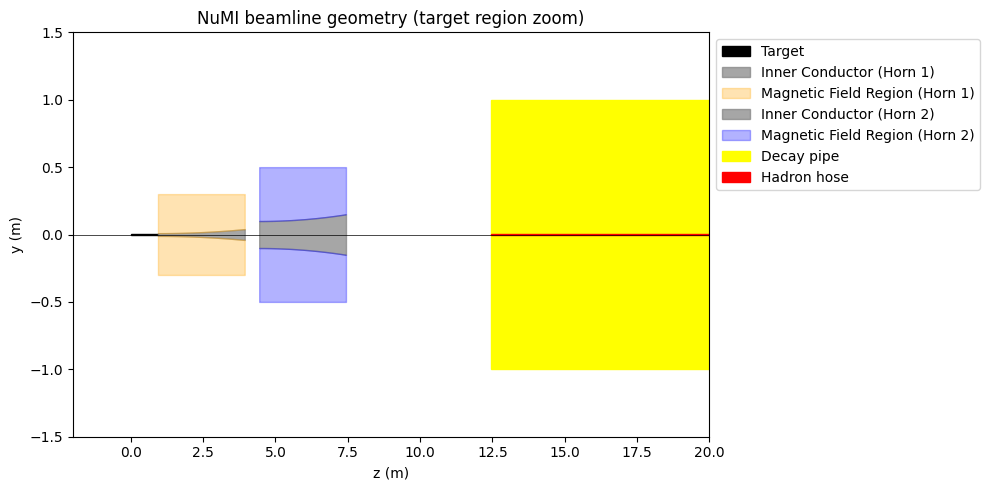

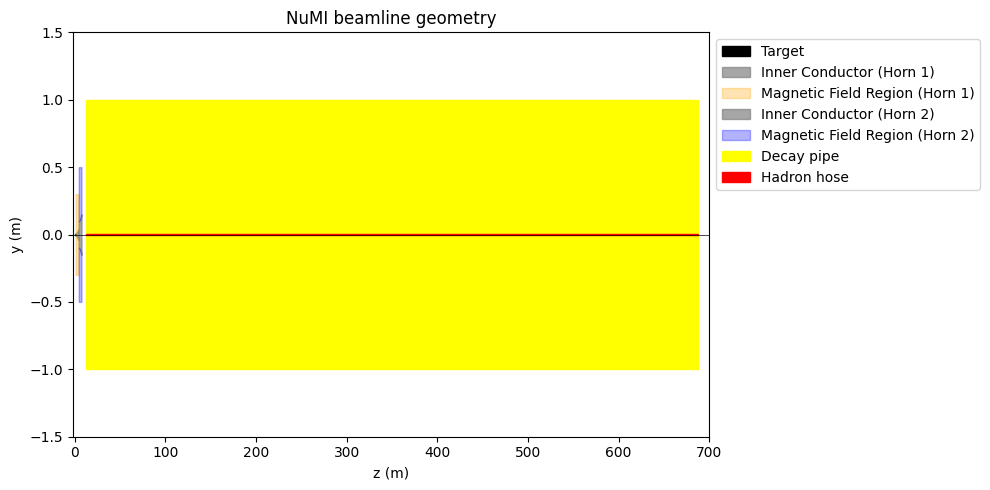

In [44]:
beamline = NuMI()

fig, ax = plt.subplots(figsize=(10, 5))   
beamline.draw_beamline_yz(fig,ax,[-1.5,1.5],[-2.0,20.0],"NuMI beamline geometry (target region zoom)")
plt.tight_layout()
plt.show()
 
fig, ax = plt.subplots(figsize=(10, 5))   
beamline.draw_beamline_yz(fig,ax,[-1.5,1.5],[-2.0,700.0],"NuMI beamline geometry")
plt.tight_layout()
plt.show()

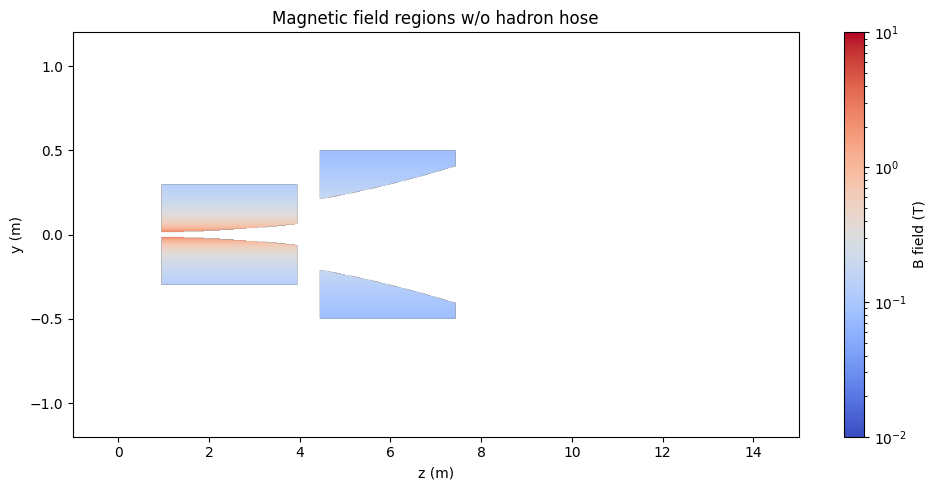

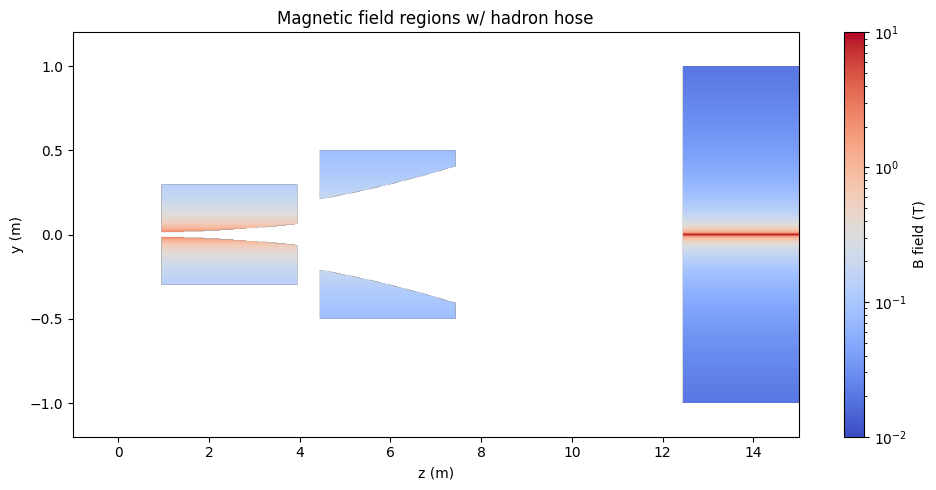

In [45]:
beamline_actual = NuMI(with_hadron_hose=False)

fig, ax = plt.subplots(figsize=(10, 5))   
beamline_actual.draw_magnetic_field_magnitude_yz(
    fig,ax,[-1.2,1.2],[-1.0,15.0],"Magnetic field regions w/o hadron hose")
plt.tight_layout()
plt.show()

beamline_with_hose = NuMI(with_hadron_hose=True)

fig, ax = plt.subplots(figsize=(10, 5))   
beamline_with_hose.draw_magnetic_field_magnitude_yz(
    fig,ax,[-1.2,1.2],[-1.0,15.0],"Magnetic field regions w/ hadron hose")
plt.tight_layout()
plt.show()

## Implementation of a particle tracker

***Deriving the differential equation to solve***

$\displaystyle dE_p = \vec{F} \cdot d\vec{\ell} = q(\vec{E} + \vec{u}_p \times \vec{B}) \cdot d\vec{\ell} 
\Rightarrow \frac{dE_p}{dt} = q(\vec{E} + \vec{u}_p \times \vec{B}) \cdot \frac{d\vec{\ell}}{dt}
\Rightarrow \frac{dE_p}{dt} = q \vec{E} \cdot \vec{u}_p$

<!-- $\displaystyle \frac{d\vec{p}_p}{dt} = \vec{F}_p \xRightarrow{\beta=u/c=pc/E \Rightarrow p = E u / c^2} \frac{1}{c^2} E_p \frac{d\vec{u}_p}{dt} = q(\vec{E} + \vec{u}_p \times \vec{B})$
 -->

$\displaystyle \frac{d\vec{p}_p}{dt} = \vec{F}_p \Rightarrow \frac{d\vec{p}_p}{dt} = q(\vec{E} + \vec{u}_p \times \vec{B})$

$\displaystyle \frac{d\vec{x}_p}{dt}=\vec{u}_p$


$\displaystyle 
\vec{S} = 
    \begin{pmatrix} 
    E_p \\ (\vec{p}_p)_x \\ (\vec{p}_p)_y \\ (\vec{p}_p)_z \\ t_p \\ (\vec{x}_p)_x \\ (\vec{x}_p)_y \\ (\vec{x}_p)_z 
    \end{pmatrix}, \;\; 
\frac{d\vec{S}}{dt} =   
    \frac{d}{dt}    
      \begin{pmatrix} 
         E_p \\ (\vec{p}_p)_x \\ (\vec{p}_p)_y \\ (\vec{p}_p)_z \\ t_p \\ (\vec{x}_p)_x \\ (\vec{x}_p)_y \\ (\vec{x}_p)_z 
      \end{pmatrix} = 
    \begin{pmatrix} 
    q \vec{E} \cdot \vec{u}_p \\ 
    q(\vec{E} + \vec{u}_p \times \vec{B})_x \\ q(\vec{E} + \vec{u}_p \times \vec{B})_y \\ q(\vec{E} + \vec{u}_p \times \vec{B})_z \\ 
    1 \\ 
    (\vec{u}_p)_x \\ (\vec{u}_p)_y \\ (\vec{u}_p)_z 
\end{pmatrix} = f(t,\vec{S})
$

***Numerical methods for solving a differential equation***

We will use the following methods to solve the differential equation 
$\displaystyle \frac{d\vec{S}}{dt} = f(t,\vec{S})$

*Euler method:*

$\displaystyle
\vec{S}_{i+1} = \vec{S}_{i} + \vec{k}_1 dt$   

where 
$\displaystyle 
\vec{k}_1 = f(t_i, \vec{S}_i)$

*Runge-Kutta 2nd order method (Heun's method):*

$\displaystyle
\vec{S}_{t+1} = \vec{S}_{t} + \frac{1}{2} \Big( \vec{k}_1 + \vec{k}_2 \Big) dt$   

where
$\displaystyle 
\vec{k}_1 = f(t_i, \vec{S}_i), \;
\vec{k}_2 = f(t_i+dt, \vec{S}_i + \vec{k}_1 dt)$

Here, $\frac{1}{2} \Big( \vec{k}_1 + \vec{k}_2 \Big)$ is the average of the slopes at the beginning and at the end of the current step.


In [46]:
class ParticleTracker:

    """
    A simple ParticleTracker class, propagating a particle within uniform electric and magnetic fields
    """

    def __init__ (self, Q, state_0, t_final, dt, Efield_func, Bfield_func, method="RK2", n_steps_print=0):

        assert(dt < t_final)
        
        self._Q           = Q # charge of the particle to be propagated
        self._ti          = state_0[4] # initial time (in s)
        self._tf          = np.float64(t_final) # desired end time simulated (in s)
        self._dt          = np.float64(dt) # desired time increment (in s)
        self._Efield_func = Efield_func # a function computing the electric field (in V/m) for the input t (in s), and x,y,z (in m)
        self._Bfield_func = Bfield_func # a function computing the magnetic field (in T) for the input t (in s), and x,y,z (in m)
        self._method      = method # method solving the equation of motion: one of "Euler" or "RK2", or "RK4"
        self._nstepsprint = n_steps_print # number of steps where detailed debugging printout is produced
        self._cstep       = 0 # current step        
        self._nsteps      = 0 # number of steps
        self._maxsteps    = int(2*(self._tf-self._ti)/dt)  # a safe maximum number of steps
        self._track       = np.zeros((self._maxsteps,8), dtype=np.float64)  # particle trajectory in state vector space
        self._track[0]    = state_0 # starting point for the trajectory
            
    @property
    def track(self):
        return self._track

    @property
    def nsteps(self):
        return self._nsteps
    
    # Propagate the particle for the required length of time within the input
    # \vec{E} (in V/m) and \vec{B} (in T) fields
    #
    def propagate(self):

        t = self._ti

        print(f"@propagate: Tracking particle from t = {self._ti} s to {self._tf} s in {self._dt} s increments")
        print(f"@propagate: Method: {self._method}") 
       
        while t < self._tf:

            debug_printout = True if self._cstep < self._nstepsprint else False
            
            dt = self._dt if self._dt < self._tf - t else  self._tf - t # time increment
            if (debug_printout):            
                print(f"\n@propagate: Step = {self._cstep+1} - Time = {t} s -> {t+dt} s, an increment of {dt} s")

            # Get the current state vector (E,px,py,pz,t,x,y,z) (in GeV, s and m)
            s = self._track[self._cstep]
            if (debug_printout):
                print(f"@propagate: State vector (E,px,py,pz,t,x,y,z) at the start of the step = \n {s}")

            # Calculate the rate of change of the state vector
            ds_dt = np.zeros(8, dtype=np.float64)
            if self._method == "Euler": 
                ds_dt = self.rates_of_change(s, debug_printout)
            elif self._method == "RK2":
                k1 = self.rates_of_change(s,       debug_printout)
                k2 = self.rates_of_change(s+dt*k1, debug_printout)
                ds_dt = (k1 + k2)/2
            elif self._method == "RK4":
                k1 = self.rates_of_change(s,          debug_printout)
                k2 = self.rates_of_change(s+dt*k1/2., debug_printout)
                k3 = self.rates_of_change(s+dt*k2/2., debug_printout)
                k4 = self.rates_of_change(s+dt*k3,    debug_printout)
                ds_dt = (k1 + 2*k2 + 2*k3 + k4)/6.
            else:
                print(f"@propagate: Method {self._method} is not  recognized!")
                exit()
                
            # Calculate the updated state vector
            s_new = s + dt*ds_dt
            if (debug_printout):
                print(f"@propagate: Updated state vector = \n {s_new}")

            # Store the updated state vector & update time
            self._cstep += 1
            self._track[self._cstep] = s_new
            t = t + dt
            
        self._nsteps = self._cstep

        print(f"@propagate:Particle trajectory was successfully simulated to t = {t} in {self._nsteps} steps")
        print(f"@propagate:Last time increment used was {dt} s")
        print(f"@propagate:State vector at end of propagation:\n {s_new}\n")
        
        return

    # Calculate d(E,px,py,pz,t,x,y,z)/dt for the current state of the propagating particle, 
    # which is experiencing the input \vec{E} (in V/m) and \vec{B} (in T) fields
    #
    def rates_of_change(self, state, debug_printout=False):

        f = np.float64(1.0E-9) # factor required for conversion of units
        Q = self._Q  # particle charge 
        u = (state[1:4]/state[0]) * c # (ux,uy,uz) in m/s
        E = self._Efield_func(state[4:]) # electric field in V/m for current t,x,y,z
        B = self._Bfield_func(state[4:]) # magnetic field in T for current t,x,y,z
        
        if (debug_printout):
            print(f"Q = {Q} |e|")
            print(f"u = {u} m/s")
            print(f"(Ex,Ey,Ez) = {E} V/m")
            print(f"(Bx,By,Bz) = {B} T")
        
        # Work out the q \vec{E} \cdot \vec{u} dot product related to the rate of change of work dW/dt
        #
        dWdt = f * Q * np.dot (E,u) # in GeV/s
        
        # Work out q \vec{E} and the q \vec{u} \times \vec{B} cross product related to the Lorentz force        
        #
        FE   = f*c*Q * E              # Electric force
        FB   = f*c*Q * np.cross(u,B)  # Magnetic force
        FL   = FE + FB                # Lorentz force in GeV/s
                        
        # Return a vector of derivatives d(E,px,py,pz,t,x,y,z)/dt with the units stripped out
        dstate_dt = np.array([dWdt,FL[0],FL[1],FL[2],1,u[0],u[1],u[2]],dtype=np.float64)        

        if (debug_printout):
            print(f"Rate of change of state vector: \n {dstate_dt}")

        return dstate_dt


**Test the particle tracker simulating the propagation of single particles in simple electric and magnetic fields**

@propagate: Tracking particle from t = 0.0 s to 3e-08 s in 2e-10 s increments
@propagate: Method: RK2
@propagate:Particle trajectory was successfully simulated to t = 3e-08 in 151 steps
@propagate:Last time increment used was 9.926167350636332e-23 s
@propagate:State vector at end of propagation:
 [6.00000218e-01 3.57665423e-01 4.82656566e-01 1.00000000e+00
 3.00000000e-08 5.36656335e-01 2.69447047e-01 1.49896175e+01]



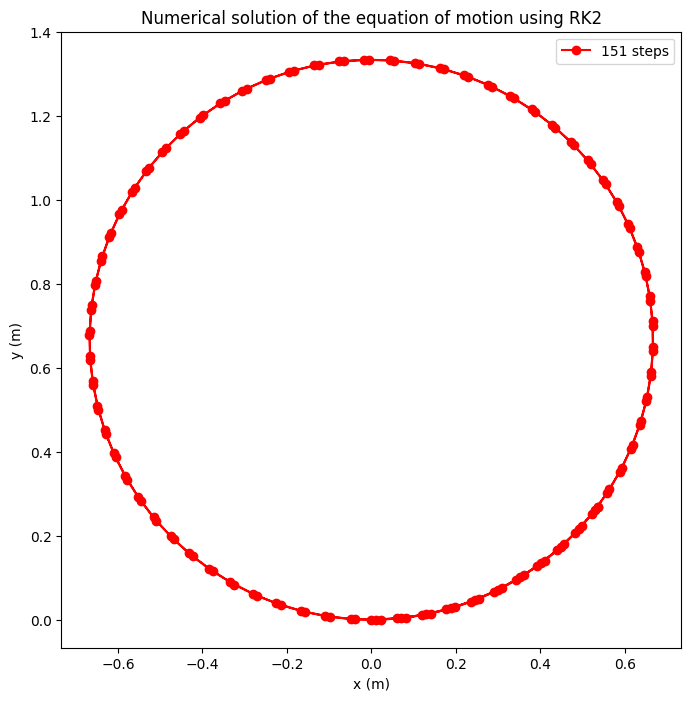

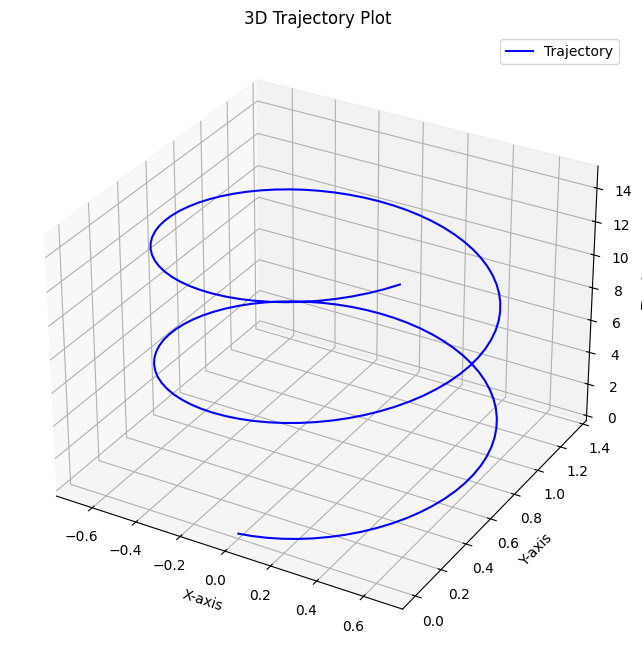

In [47]:
mass    = np.float64(0.000511)                  # GeV
charge  = np.float64(-1)                        # |e|
px      = np.float64(0.6)                       # GeV
pz      = np.float64(1.0)                       # GeV
E       = np.sqrt(mass**2+px**2)
state_0 = np.array([E, px, 0, pz, 0, 0, 0, 0], dtype=np.float64) 
Bfield  = np.array([0, 0, 3], dtype=np.float64) # Tesla
Efield  = np.array([0, 0, 0], dtype=np.float64) # V/m
t_final = np.float64(3E-8)  # sec
dt      = np.float64(2E-10) # sec

# Define functions that return the electric and magnetic field vectors, as expected by ParticleTracker
# In this example, they are just the uniform fields defined previously
def electric_field(x4):
    return Efield

def magnetic_field(x4):
    return Bfield    
    
tracker = ParticleTracker(charge, state_0, t_final, dt, electric_field, magnetic_field, "RK2", 0)
tracker.propagate()

npoints = tracker.nsteps+1
xarr    = tracker.track[:npoints,5]
yarr    = tracker.track[:npoints,6]
zarr    = tracker.track[:npoints,7]

plt.figure(figsize=((8,8)))
plt.plot(xarr, yarr, color='r', linestyle='-', marker='o', label=f"{tracker.nsteps} steps")
plt.title("Numerical solution of the equation of motion using RK2")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(xarr, yarr, zarr, label="Trajectory", color="b")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("3D Trajectory Plot")
ax.legend()
plt.show()

@propagate: Tracking particle from t = 0.0 s to 4e-07 s in 2e-10 s increments
@propagate: Method: RK2
@propagate:Particle trajectory was successfully simulated to t = 4e-07 in 2000 steps
@propagate:Last time increment used was 1.9999999999397992e-10 s
@propagate:State vector at end of propagation:
 [ 2.44540385e-01 -1.14881908e-02 -7.83780677e-03  2.01104589e-01
  4.00000000e-07 -4.78204847e+00 -3.35251020e+00  9.82447637e+01]



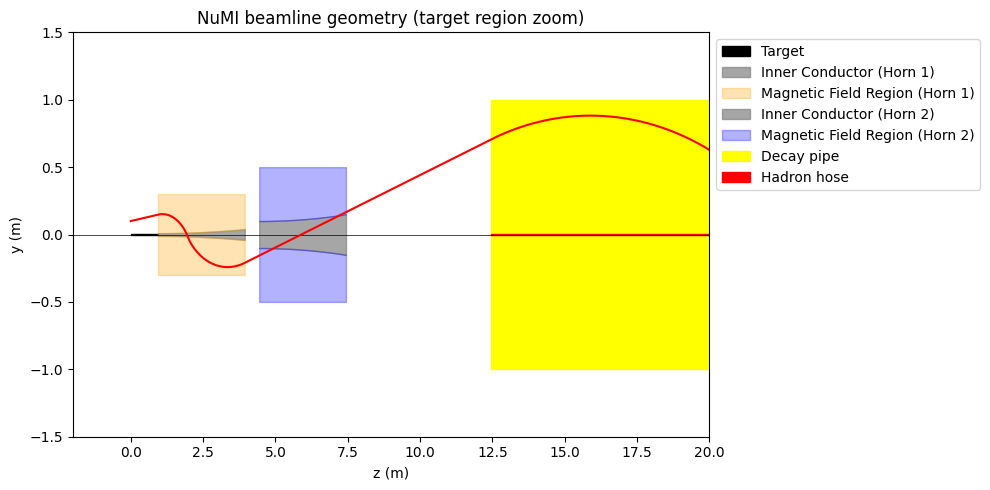

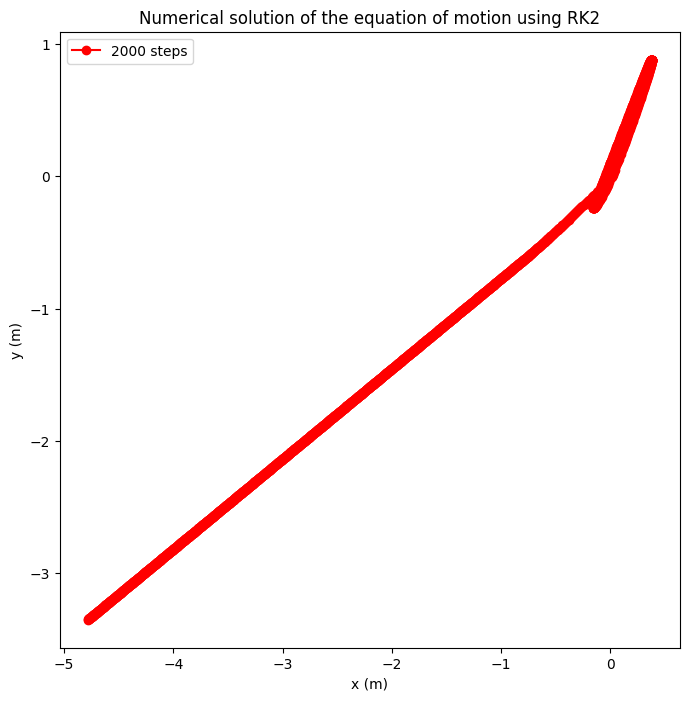

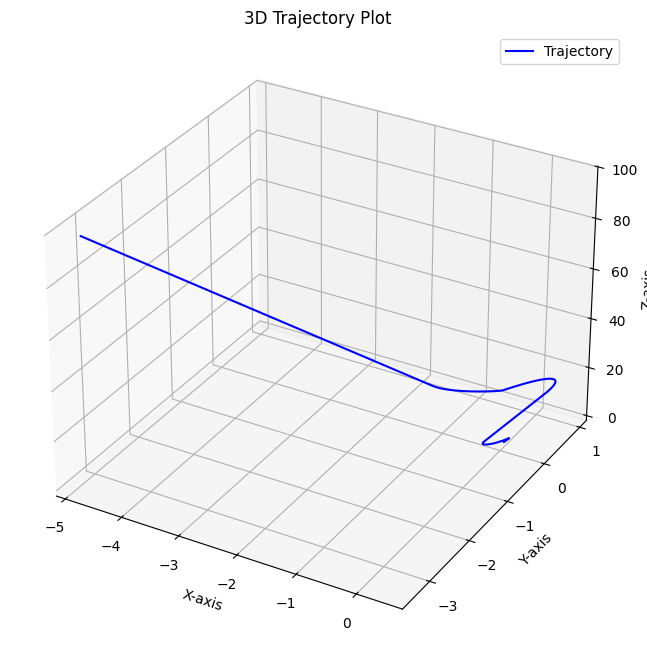

In [48]:
mass    = np.float64(0.140)                     # GeV
charge  = np.float64(+1)                        # |e|
px      = np.float64(0.01)                       # GeV
py      = np.float64(0.01)                       # GeV
pz      = np.float64(0.2)                       # GeV
E       = np.sqrt(mass**2+px**2+py**2+pz**2)    # GeV
state_0 = np.array([E, px, py, pz, 0, 0, 0.1, 0], dtype=np.float64) 
t_final = np.float64(4E-7)  # sec
dt      = np.float64(2E-10) # sec

beamline_with_hose = NuMI(with_hadron_hose=True)

tracker = ParticleTracker(
    charge, state_0, t_final, dt, 
    beamline_with_hose.electric_field, beamline_with_hose.magnetic_field, "RK2", 0)
tracker.propagate()

npoints = tracker.nsteps+1
xarr    = tracker.track[:npoints,5]
yarr    = tracker.track[:npoints,6]
zarr    = tracker.track[:npoints,7]

fig, ax = plt.subplots(figsize=(10, 5))   
beamline.draw_beamline_yz(fig,ax,[-1.5,1.5],[-2.0,20.0],"NuMI beamline geometry (target region zoom)")
# beamline_with_hose.draw_magnetic_field_magnitude_yz(
#     fig,ax,[-1.2,1.2],[-1.0,40.0],"Magnetic field regions w/ hadron hose")
ax.plot(zarr, yarr, color='r', linestyle='-', marker='', label=f"{tracker.nsteps} steps")
plt.tight_layout()
plt.show()

plt.figure(figsize=((8,8)))
plt.plot(xarr, yarr, color='r', linestyle='-', marker='o', label=f"{tracker.nsteps} steps")
plt.title("Numerical solution of the equation of motion using RK2")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(xarr, yarr, zarr, label="Trajectory", color="b")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("3D Trajectory Plot")
ax.legend()
plt.show()

## References

\[1\] P. Adamson et al., *The NuMI Neutrino Beam*, 
      [Nucl.Instrum.Meth.A 806 (2016) 279-306](https://inspirehep.net/literature/1384774)

\[2\] J. Hylen et al., *The Hadron Hose: Continuous Toroidal Focusing for Conventional Neutrino Beams*,
      [Nucl.Instrum.Meth.A 498 (2003) 29-51](https://inspirehep.net/literature/591960)

\[3\] L. Aliaga et al, *Neutrino Flux Predictions for the NuMI Beam*,
      [Phys.Rev.D 94 (2016) 9, 092005, Phys.Rev.D 95 (2017) 3, 039903 (addendum)](https://inspirehep.net/literature/1473668)